In [315]:
from statistics import mean
from PIL import Image, ImageOps, ImageEnhance
import glob
import os
from os import listdir
import cv2 as cv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import image as mpimg
import numpy as geek
import numpy.matlib
import cv2
import zipfile
import numpy as np
from pathlib import Path
from numpy.linalg import inv
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import scipy.linalg as la

from sklearn.preprocessing import StandardScaler

import eigen_training
import Kmeans
import Knn
import time
import pandas as pd
import zipfile
from skimage import color
from sklearn.model_selection import train_test_split
import seaborn as sb
from tqdm import tqdm

In [316]:
# Funzione che mi permette di ritornare gli indici associati ad un valore
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

In [317]:
# Funzione che mi converte i numeri immaginari in reali
def pop_imaginary_part(data):
    x = pd.DataFrame(columns=data.columns)
    for i in data.index:
        for j in data.columns:
            x.loc[i,j] = data.iloc[i,j].real
    return x


In [318]:
# Funzione che esegue PCA
def PCA_Scratch(X,T):   
    autovettori, autovalori = eigen_training.eigen(X)
    U = autovettori[:,0:T]
    X_pca = np.dot(U.T, X)
    return X_pca, autovettori, autovalori

# Images prepare

In [319]:
#------------------------------
# keypoint_loc : file contenente per ogni immagine i punti che delineano la figura della persona
# verranno utilizzati per ridimensionare l'immagine al solo viso
key_points={}
file = open("keypoints/keypoints_loc.txt", "r")
lines = file.readlines()
file.close()

for data in lines:
    key_points[data.split()[0]] = data.split()
#------------------------------
 

faces={} #dizionario contenente le immagini come items e il loro nome come key
label_gender= [] # lista delle classi associate ad ogni immagine

with zipfile.ZipFile('images.zip', 'r') as facezip:
    
    # prendiamo solo 20000 immagini per impiegare meno tempo nel processamento di queste
    female = facezip.namelist()[-10000:]
    male = facezip.namelist()[:10000]
    image = [*male, *female]

    # scommentare e commentare la parte sopra per prenderle tutte (numero totale di immagini: 44053)
    #image = facezip.namelist()

    print("Numero di immagini: ", len(image) )

    for img in image :
        if not img.endswith(".jpg"):
            continue
        with facezip.open(img) as image:
            
            n = img.split("/")
            name =n[1]
            point= key_points.get(name)

            if(point != None):
                point1y= int(point[2]) 
                point1x = int(point[3]) -12
                img_pil = Image.open(image).convert('L')

                #ritaglio l'immagine con crop secondo l'area specificata dai punti presi in keypoints_loc
                area =(point1x,point1y, point1x+115, point1y+150)
                cropped_img = img_pil.crop(area) 
                data = np.asarray(cropped_img)
                
                if data.size != 0:
                    if(name[:3] == "MEN"):
                        label_gender.append(0)
                    else:
                        label_gender.append(1)
                    faces[name]=data

#------------------------------------
# al termine del processo otterremo un numero di immagini minore rispetto all'inizio poichè nel mentre 
# si sono eliminate le immagini che risultavano senza volto con data.zie !=0
print("Numero immagini dopo la selezione: ",len(faces))


#creo una matrice TMP con le immagini sulle colonne
facelist= list(faces.items())
row,col= facelist[1][1].shape
TMP = np.zeros((row*col, len(facelist)))
i=0
while i<len(facelist):
    tmp = facelist[i][1]
    tmp = np.reshape(tmp,(-1,1)) 
    TMP[:,i] = tmp.flatten()
    i+=1



Numero di immagini:  20000
Numero immagini dopo la selezione:  4709


### Plot Image
Per visualizzare le immagini

In [320]:
"""
list_tmp = list(faces.items())
print(list_tmp[1][1])

fig=plt.figure(figsize=(100, 500))
col=5
row=135
for i in range(1,col*row +1):
    img= list_tmp[i][1]
    
    fig.add_subplot(row, col, i)
    plt.imshow(img)
plt.show
"""

'\nlist_tmp = list(faces.items())\nprint(list_tmp[1][1])\n\nfig=plt.figure(figsize=(100, 500))\ncol=5\nrow=135\nfor i in range(1,col*row +1):\n    img= list_tmp[i][1]\n    \n    fig.add_subplot(row, col, i)\n    plt.imshow(img)\nplt.show\n'

### Plot image point

In [321]:
#creo un DataFrame data che ha le immagini sulle righe 
data_TMP= pd.DataFrame(TMP.T)
#data.head()

(150, 115)


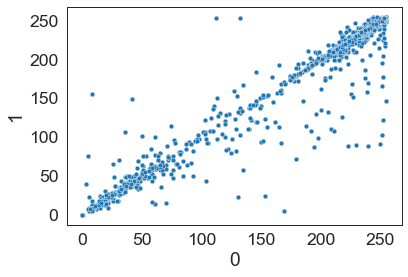

In [322]:
sb.scatterplot(data= data_TMP, x=0, y=1)
print(data.shape)

# PCA

Andiamo a ridurre la dimensionalità delle immagini con PCA

In [323]:
# Standardizzo i dati rimuovendo la media e ridimensionando in base alla varianza unitaria.
# fit: Calcola la media e lo std da utilizzare per il ridimensionamento successivo.
# transform: Eseguire la standardizzazione centrando e ridimensionando.
scaler = StandardScaler()
scaler.fit(data_TMP)
X = scaler.transform(data_TMP)

In [324]:
X.shape

(4709, 17250)

In [326]:
X_pca, autovettori, autovalori= PCA_Scratch(X.T,90) #immagini per colonne

(4709, 4709)


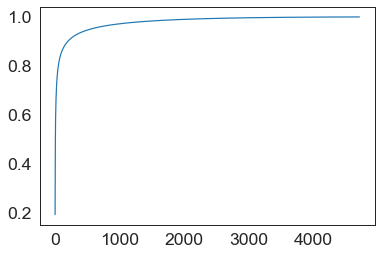

In [327]:
y = np.cumsum(autovalori.T)/np.sum(autovalori.T)
fig = plt.figure()
ax = plt.axes()
ax.plot(y)

In [328]:
X_pca= X_pca.T  # traspongo le immagini per righe
print(X_pca.shape) #vediamo che abbiamo ridotto la dimensionalità delle immagini
# X_pca : N x D   (N: numero immagini , D: dimensionalità)

(4709, 90)


### Plot pca image point

<AxesSubplot:xlabel='0', ylabel='1'>

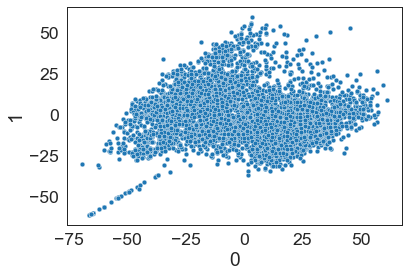

In [329]:
data_pca= pd.DataFrame(X_pca)
sb.scatterplot(data= data_pca, x=0, y=1)

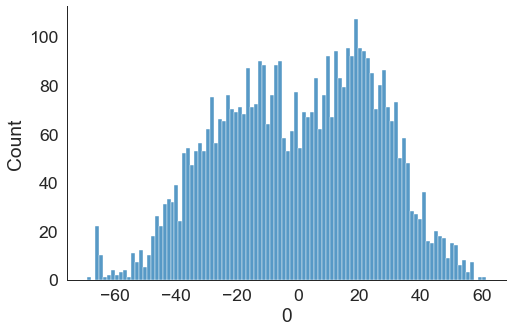

In [330]:
t=pop_imaginary_part(data_pca)
sb.set_style('white')
sb.set_context("paper", font_scale = 2)
sb.displot(data= t, x=0, kind="hist", bins = 100, aspect = 1.5)

In [331]:
data_pca= data_pca.T
data_pca.columns= list(faces.keys())
data_pca=data_pca.T

# KMeans

### Split data in Training and Testing

In [332]:
train, test = train_test_split( data_pca, test_size=1/2, random_state=0)

In [333]:
# funzione per calcolare la postirior di una classe
from numpy import var
from scipy.stats import multivariate_normal

def normal_d(X, validation, N, centroids):
    matcov=np.identity(X.shape[1])
    variance= var(X)
    matcov= np.dot(matcov,variance)
    weight= X.shape[0]/N
    mvn = multivariate_normal(centroids,matcov) 
    p = np.log(mvn.pdf(validation)* weight )
    return p, weight, matcov

# Clusterin with K=2

# Training

In [334]:
X_train= train.to_numpy()
X_test= test.to_numpy()
K=2
centroids,index, confmat= Kmeans.kmeans_init(X_train, K,10)

# Testing

In [335]:
label_test1=np.zeros(X_test.shape[0])
N= X_train.shape[0]
print(label_test1.shape)
confmat_km=np.zeros((K,K))
confmat_knn=np.zeros((K,K))

for i in tqdm(range(X_test.shape[0])):
    p={}
    for j in range(2):
        X_j= X_train[indices(index, lambda x: x==j),:]
        p[j]=normal_d(X_j, X_test[i:i+1,:],N, centroids[j,:])
    classe= max(p, key= lambda x: p[x])
    label_test1[i]=classe


(2355,)


100%|██████████| 2355/2355 [00:10<00:00, 235.16it/s]


In [340]:
label_test2=np.zeros(X_test.shape[0])
for i in tqdm(range(X_test.shape[0])):
    y_test= Knn.knn_init(X_train,X_test[i:i+1,:],index,2,15)
    label_test2[i]= y_test


100%|██████████| 2355/2355 [00:51<00:00, 45.63it/s]


#### Plot Training KMeans Cluster

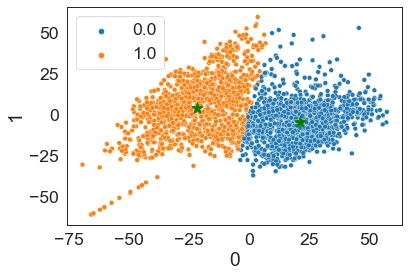

In [337]:
cdict={0:'red',1:'blue'}
sb.scatterplot(data= train, x=0, y=1, hue=index)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='g', s=150)

#### Plot Testing Bayes Cluster

<AxesSubplot:xlabel='0', ylabel='1'>

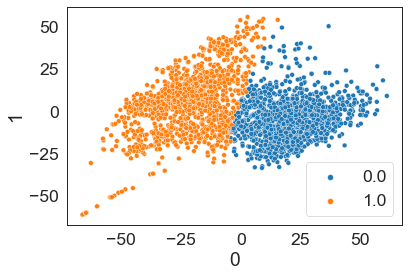

In [338]:
sb.scatterplot(data=test, x=0, y=1, hue=label_test1 )

#### Plot Testing Knn Cluster

<AxesSubplot:xlabel='0', ylabel='1'>

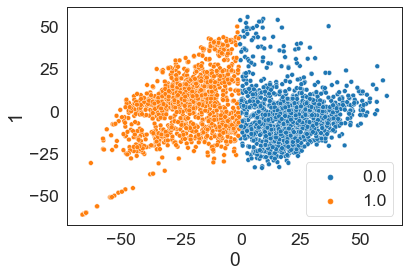

In [341]:
sb.scatterplot(data=test, x=0, y=1, hue=label_test2 )

# Clusterin with K=3

In [342]:
train, test = train_test_split( data_pca, test_size=1/7.0, random_state=0)


# KMeans

In [343]:
X_train= train.to_numpy()
X_test= test.to_numpy()
K=3
centroids,index, confmat= Kmeans.kmeans_init(X_train, K,10)

In [344]:
label_test1=np.zeros(X_test.shape[0])
N= X_train.shape[0]
confmat_km=np.zeros((K,K))
confmat_knn=np.zeros((K,K))

for i in tqdm(range(X_test.shape[0])):
    p={}
    for j in range(K):
        X_j= X_train[indices(index, lambda x: x==j),:]
        p[j]=normal_d(X_j, X_test[i:i+1,:],N, centroids[j,:])
    classe= max(p, key= lambda x: p[x])
    label_test1[i]=classe

    

(673,)


100%|██████████| 673/673 [00:05<00:00, 114.13it/s]


In [345]:
label_test2=np.zeros(X_test.shape[0])
for i in tqdm(range(X_test.shape[0])):
    y_test= Knn.knn_init(X_train,X_test[i:i+1,:],index,2,15)
    label_test2[i]= y_test


100%|██████████| 673/673 [00:28<00:00, 23.55it/s]


#### Plot Training KMeans Cluster

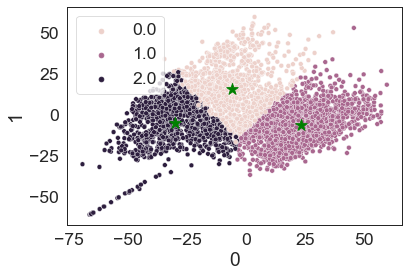

In [346]:
sb.scatterplot(data= train, x=0, y=1, hue=index)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='g', s=150)

#### Plot Testing Bayes Cluster

<AxesSubplot:xlabel='0', ylabel='1'>

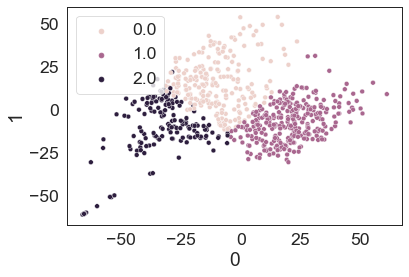

In [347]:
sb.scatterplot(data=test, x=0, y=1, hue=label_test1 )

#### Plot Testing Knn Cluster

<AxesSubplot:xlabel='0', ylabel='1'>

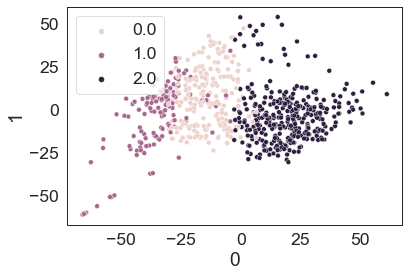

In [ ]:
sb.scatterplot(data=test, x=0, y=1, hue=label_test2 )

Con K=3 il sistema sembra dover riconoscere le immagini delle seguenti classi: *Capelli corti*, *Capelli chiari*, *Capelli lunghi scuri*.

Andiamo a fare una verifica: prendiamo 4 immagini di ogni classe e la plottiamo per cogliere le similitudini e le differenze.

In [348]:
test['ClusterBayes']= label_test1
test['ClusterKnn']= label_test2

In [349]:

B_0 = test.loc[test.ClusterBayes == 0, :]
B_1 = test.loc[test.ClusterBayes == 1, :]
B_2 = test.loc[test.ClusterBayes == 2, :]
B_3 = test.loc[test.ClusterBayes == 3, :]


In [350]:

K_0 = test.loc[test.ClusterKnn == 0, :]
K_1 = test.loc[test.ClusterKnn == 1, :]
K_2 = test.loc[test.ClusterKnn == 2, :]
K_3 = test.loc[test.ClusterKnn == 3, :]

In [351]:
Bname_0= B_0.index[:4]
Bname_1= B_1.index[8:12]
Bname_2= B_2.index[4:8]

In [355]:
Kname_0= K_0.index[:4]
Kname_1= K_1.index[8:12]
Kname_2= K_2.index[4:8]

In [356]:
Bimages=[]
for i in range(4):
    Bimages.append(faces[Bname_0[i]])
for i in range(4):
    Bimages.append(faces[Bname_1[i]])
for i in range(4):
    Bimages.append(faces[Bname_2[i]])
    
Kimages=[]
for i in range(4):
    Kimages.append(faces[Kname_0[i]])
for i in range(4):
    Kimages.append(faces[Kname_1[i]])
for i in range(4):
    Kimages.append(faces[Kname_2[i]])

In [357]:
fig=plt.figure(figsize=(15, 20))
col=4
row=4
j=0
for i in range(1,col*row +1):
    img= Bimages[j]
    
    fig.add_subplot(row, col, i)
    plt.imshow(img)
    j+=1
plt.show

'fig=plt.figure(figsize=(100, 500))\ncol=4\nrow=4\nj=0\nfor i in range(1,col*row +1):\n    img= Bimages[j]\n    \n    fig.add_subplot(row, col, i)\n    plt.imshow(img)\n    j+=1\nplt.show'

IndexError: list index out of range

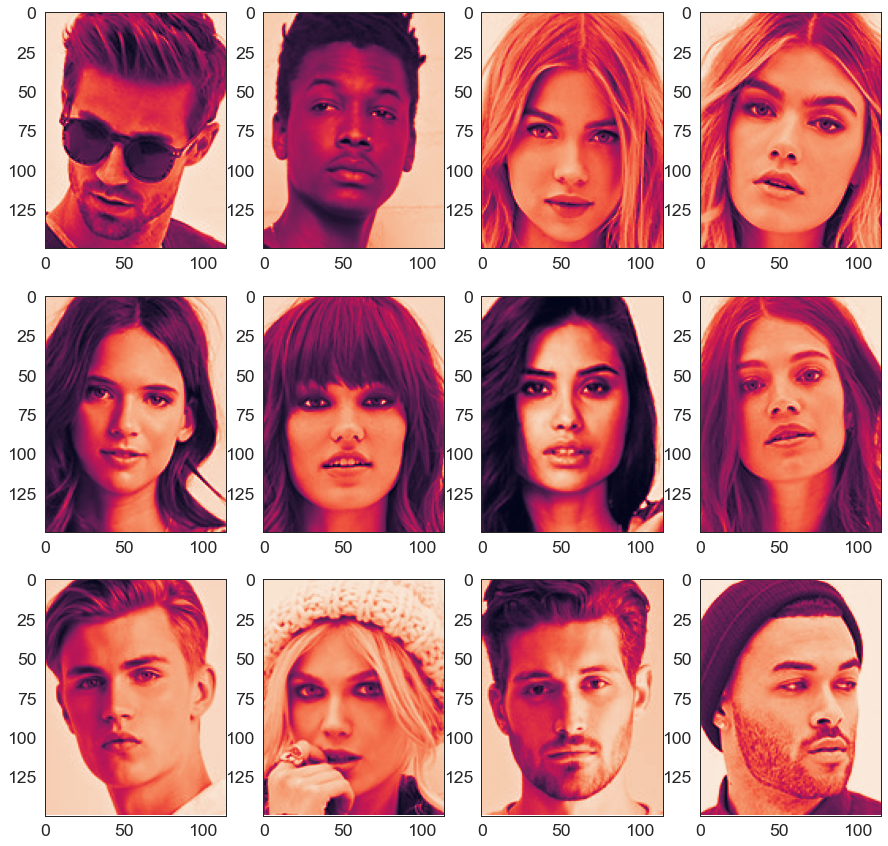

In [362]:
fig=plt.figure(figsize=(15, 20))
col=4
row=4
j=0
for i in range(1,col*row +1):
    img= Kimages[j]
    
    fig.add_subplot(row, col, i)
    plt.imshow(img)
    j+=1
plt.show

# Clusterin with K=4

In [363]:
train, test = train_test_split( data_pca, test_size=1/7.0, random_state=0)

In [364]:
X_train= train.to_numpy()
X_test= test.to_numpy()
K=4
centroids,index, confmat= Kmeans.kmeans_init(X_train, K,10)

In [366]:
label_test1=np.zeros(X_test.shape[0])
N= X_train.shape[0]
confmat_km=np.zeros((K,K))
confmat_knn=np.zeros((K,K))

for i in tqdm(range(X_test.shape[0])):
    p={}
    for j in range(K):
        X_j= X_train[indices(index, lambda x: x==j),:]
        p[j]=normal_d(X_j, X_test[i:i+1,:],N, centroids[j,:])
    classe= max(p, key= lambda x: p[x])
    label_test1[i]=classe

    

(673,)


100%|██████████| 673/673 [00:08<00:00, 78.90it/s]


In [367]:
label_test2=np.zeros(X_test.shape[0])
for i in tqdm(range(X_test.shape[0])):
    y_test= Knn.knn_init(X_train,X_test[i:i+1,:],index,2,15)
    label_test2[i]= y_test


100%|██████████| 673/673 [00:30<00:00, 22.05it/s]


#### Plot Training Kmeans Cluster

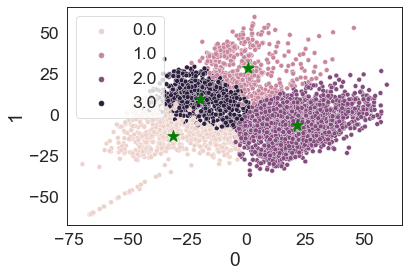

In [368]:
sb.scatterplot(data= train, x=0, y=1, hue=index)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='g', s=150)

#### Plot Testing Bayes Cluster

<AxesSubplot:xlabel='0', ylabel='1'>

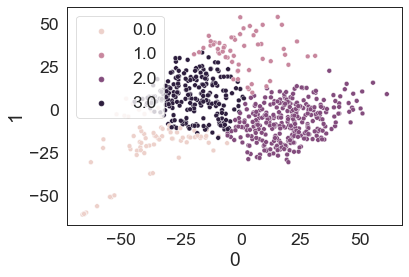

In [369]:
sb.scatterplot(data=test, x=0, y=1, hue=label_test1 )

#### Plot Testing Knn Cluster

<AxesSubplot:xlabel='0', ylabel='1'>

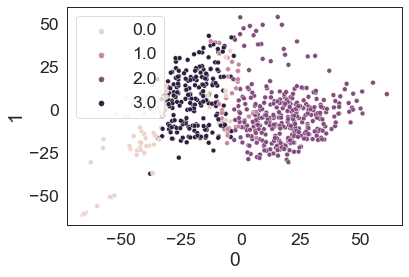

In [370]:
sb.scatterplot(data=test, x=0, y=1, hue=label_test2 )

Con K=3 il sistema sembra dover riconoscere le immagini delle seguenti classi: *Capelli corti chiari*, *Capelli corti scuri*, *Capelli chiari*, *Capelli lunghi scuri*.

Andiamo a fare una verifica: prendiamo 4 immagini di ogni classe e la plottiamo per cogliere le similitudini e le differenze.

In [371]:
test['ClusterBayes']= label_test1
test['ClusterKnn']= label_test2

In [372]:

B_0 = test.loc[test.ClusterBayes == 0, :]
B_1 = test.loc[test.ClusterBayes == 1, :]
B_2 = test.loc[test.ClusterBayes == 2, :]
B_3 = test.loc[test.ClusterBayes == 3, :]


In [373]:

K_0 = test.loc[test.ClusterKnn == 0, :]
K_1 = test.loc[test.ClusterKnn == 1, :]
K_2 = test.loc[test.ClusterKnn == 2, :]
K_3 = test.loc[test.ClusterKnn == 3, :]

In [381]:
Bname_0= B_0.index[:4]
Bname_1= B_1.index[30:34]
Bname_2= B_2.index[34:38]
Bname_3= B_3.index[34:38]

In [375]:
Kname_0= K_0.index[:4]
Kname_1= K_1.index[:4]
Kname_2= K_2.index[30:34]
Kname_3= K_3.index[30:34]

In [382]:
Bimages=[]
for i in range(4):
    Bimages.append(faces[Bname_0[i]])
for i in range(4):
    Bimages.append(faces[Bname_1[i]])
for i in range(4):
    Bimages.append(faces[Bname_2[i]])
for i in range(4):
    Bimages.append(faces[Bname_3[i]])

In [377]:

Kimages=[]
for i in range(4):
    Kimages.append(faces[Kname_0[i]])
for i in range(4):
    Kimages.append(faces[Kname_1[i]])
for i in range(4):
    Kimages.append(faces[Kname_2[i]])
for i in range(4):
    Kimages.append(faces[Kname_3[i]])

<function matplotlib.pyplot.show(close=None, block=None)>

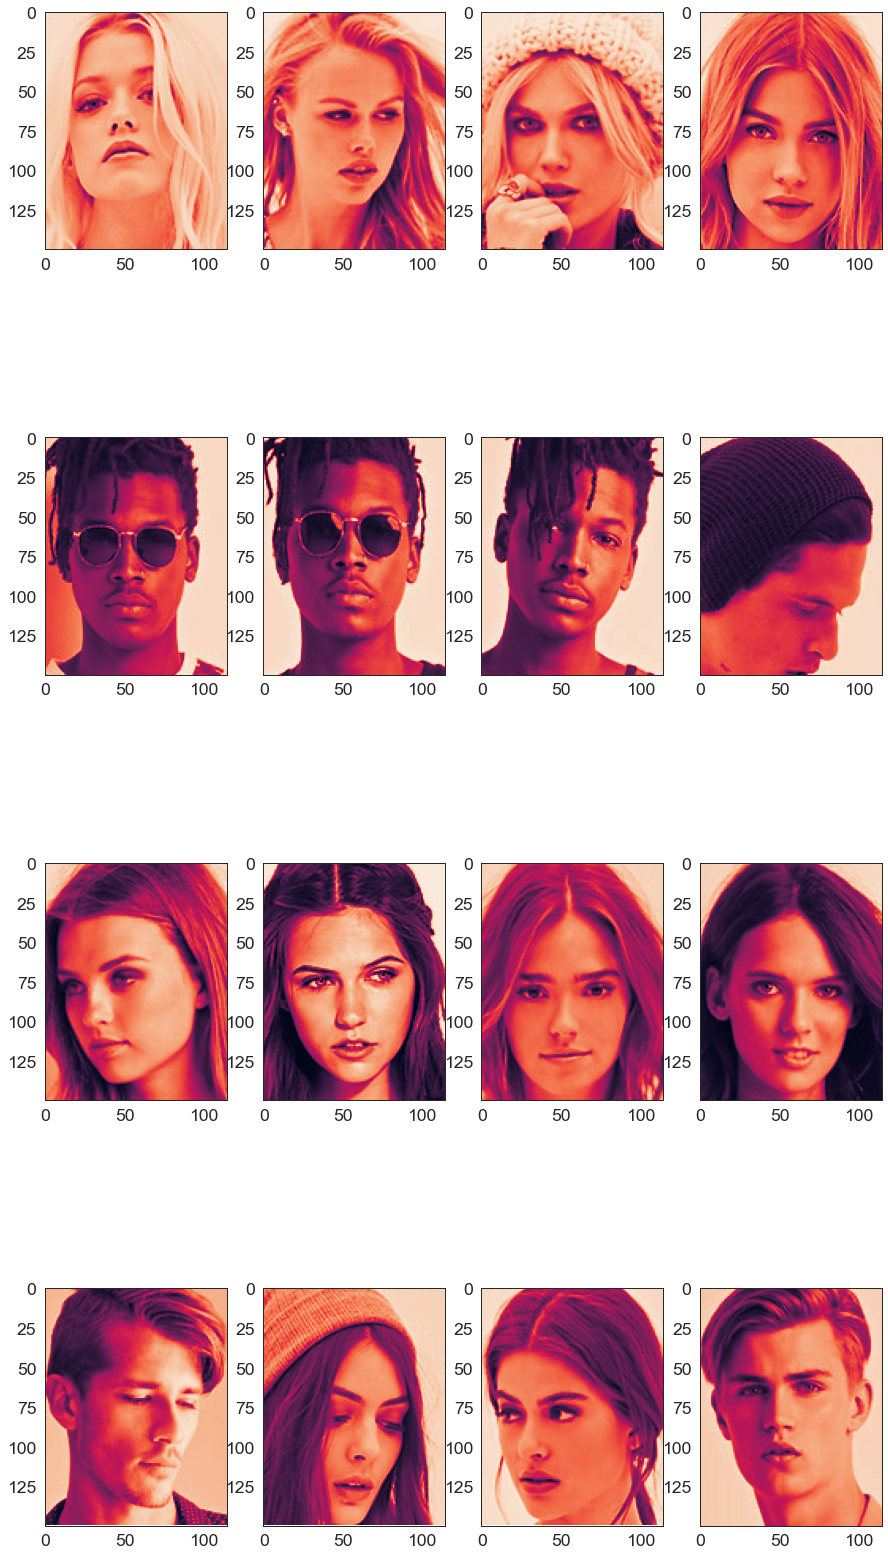

In [383]:
fig=plt.figure(figsize=(15, 30))
col=4
row=4
j=0
for i in range(1,col*row +1):
    img= Bimages[j]
    
    fig.add_subplot(row, col, i)
    plt.imshow(img)
    j+=1
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

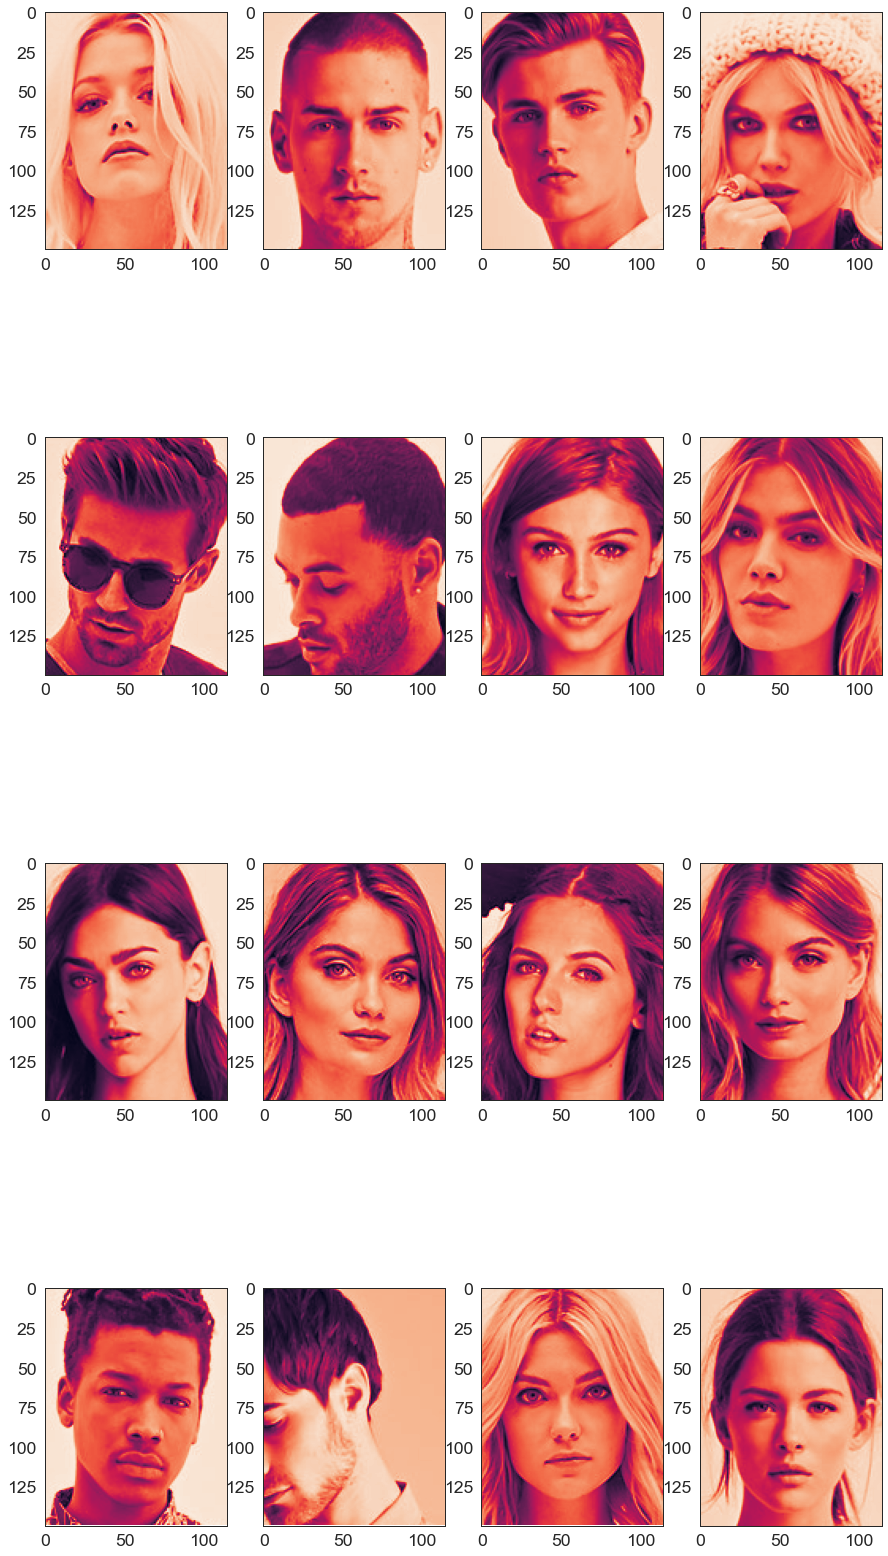

In [380]:
fig=plt.figure(figsize=(15, 30))
col=4
row=4
j=0
for i in range(1,col*row +1):
    img= Kimages[j]
    
    fig.add_subplot(row, col, i)
    plt.imshow(img)
    j+=1
plt.show